![Space Shuttle Columbia launches from the Kennedy Space Center (NASA)](./nasa-084iI8XTfN0-unsplash.jpg)

As with any software architecture, deep learning models need a delivery platform. This is the job of [NVIDIA's Triton Inference Server](https://developer.nvidia.com/triton-inference-server). The idea is conceptionally simple:

1. produce your model in one of the [supported model formats](https://github.com/triton-inference-server/backend#where-can-i-find-all-the-backends-that-are-available-for-triton) (such as [ONNX](https://onnxruntime.ai))
2. package your model with a definition file, letting Triton know how to process your model
3. run a simple Docker container from the NGC registry with your models on an S3 or other storage bucket
4. profit from a standardized inference runtime and built-in metrics

Next to reliability, the main concern of any DevOps engineer will be throughput. What good does it do the production team if models have a 0% downtime, but are so slow as to be unusable?

NVIDIA claims this is where Triton shines, indeed they have a whole section dedicated to [model optimization](https://docs.nvidia.com/deeplearning/triton-inference-server/user-guide/docs/user_guide/optimization.html).

I was more interested in a basic feature of Triton, specifically its support for [gRPC](https://docs.nvidia.com/deeplearning/triton-inference-server/user-guide/docs/protocol/README.html). In the case of model deployment, gRPC may offer a few distinct advantages:

- packing data more tightly (encoding strings or images may waste a lot of bandwith)
- repeated handshaking (for HTTP/2 or lower) loses time on every connection. gRPC creates a persistent channel, mitigating this

When choosing your Triton Inference Server version, you need to carefully evaluate the [support matrix](https://docs.nvidia.com/deeplearning/frameworks/support-matrix/index.html) for your CUDA version. For instance, for CUDA 11.7 (which is still fairly common), you need to use Triton 22.08, which was released on [March 27 2021](https://github.com/triton-inference-server/server/releases/tag/v2.8.0). 
When I first ran Triton 22.08, to my utter surprise, I found out that [gRPC ran several orders of magnitude slower then HTTP requests](https://github.com/triton-inference-server/server/issues/1821). There appeared to be a regression with the underlying Python client causing these issues.

With the advent of LLMs the Triton Inference Server has become more and more relevant, which is why I wanted to revisit this issue. In order to do so, I created a small benchmark.

## Benchmark

For this benchmark I chose the simplest model I could find from the [model repository](https://github.com/triton-inference-server/server/tree/main/docs/examples/model_repository/simple). Normally I would use [locust](https://locust.io) to run a stress-test to the service. Since Triton's Python client depends on `asyncio` rather than `gevent`, this was not possible. Instead I opted for [Molotov](https://molotov.readthedocs.io/en/stable/).

Using Motolov I evaluated different duration times $d = {10, 15, 30}$ and number of workers $w = {1, 5, 10}$.

This benchmark can be run in a few simple steps:

1. Start the Triton Server via `./run_triton.sh` (given you have Docker installed)
2. Install dependencies from `requirements.txt`
3. Run the benchmark script `python3 run_molotov.py`

### Environment

For comparibility, I will include the environment this test was conducted on:

| CPU           | RAM | Docker Engine | tritonserver | Python  | tritonclient |
|---------------|-----|---------------|--------------|---------|--------------|
| Apple M1 Chip | 8GB | 20.10.12      | 23.10-py3    | 3.10.13 | 2.36.0       |

## Results

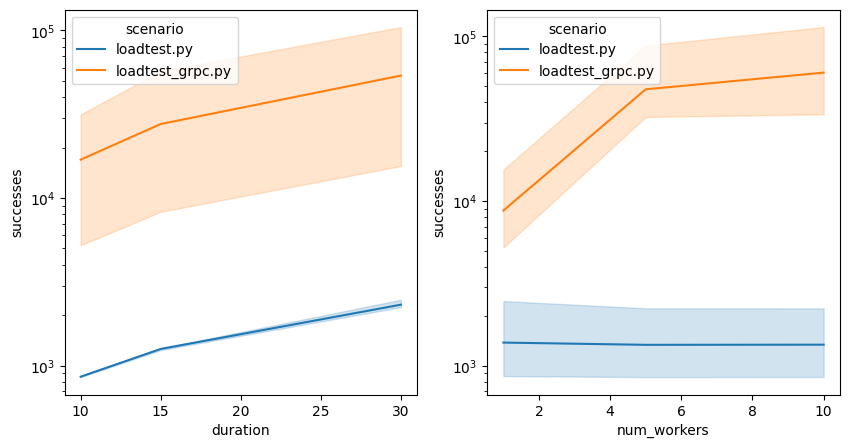

In [9]:
#| label: fig-line-successes-duration-num-workers
#| fig-cap: "A line plot showing successes in relation to total duration and number of workers"

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.read_csv("results.csv")

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].set_yscale('log')
axs[1].set_yscale('log')
sns.lineplot(df, x="duration", y="successes", hue="scenario", ax=axs[0])
sns.lineplot(df, x="num_workers", y="successes", hue="scenario", ax=axs[1])
plt.show()

@fig-line-successes-duration-num-workers shows the number of successful scenarios executed by type. One can see that longer duration correlates to more successful scenarios. In contrast, we can see the slope of successful scenarios decrease as we increase the number of workers.
These are typical trajectories of load benchmarks and indicate that the service is working correctly. From the graph it is immediately obvious that the gRPC scenario has orders of magnitudes more successes then the HTTP scenario.

## Discussion

NVIDIA has resolved the regression and (as expected) gRPC now outperforms the HTTP client significantly. This is great news for high-throughput model deployments!

### Extending the benchmark

The explicit goal of this benchmark was to test the regression related to gRPC connectivity issues. It would be useful to have a larger suite of benchmarks for the Triton Server however. If you are interested in this, please feel free to use the `run_molotov.py` as a baseline. Some areas of improvement are:

- running more parameters (larger $d$ and $w$) to find out the capacity of Triton
- running on a GPU to unleash CUDA support
- running more models from the model zoo